In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Bio import SeqIO

# Original Argonaute Fasta

In [2]:
### Retrieve True Argonaute IDs from original fasta files
# Extracting organism and seq info just in case

def extract_tag(s, tag):
    parts = s.split()
    tag_value = ''
    is_recording = False
    tag_prefix = tag + '='
    for part in parts:
        if part.startswith(tag_prefix):
            is_recording = True
            tag_value += part[len(tag_prefix):]
        elif is_recording and '=' in part and not part.startswith(tag_prefix):
            break
        elif is_recording:
            tag_value += ' ' + part
    return tag_value


def extract_targetid(s):
    return s.split('|')[1]


def read_fasta(infasta):
    fasta_dict = {}
    for record in SeqIO.parse(infasta, "fasta"):
        OS = extract_tag(record.description, 'OS')
        OX = extract_tag(record.description, 'OX')
        fasta_dict[extract_targetid(record.id)] = {'seq': str(record.seq), 'OS': OS, 'OX': OX}
    return fasta_dict


ago_fasta = '/home/moon/projects/AgoAnalysis/fasta/AGO_all.fasta'
wago_fasta = '/home/moon/projects/AgoAnalysis/fasta/WAGO_all.fasta'
piwi_fasta = '/home/moon/projects/AgoAnalysis/fasta/PIWI_all.fasta'

ago_fasta_dict = read_fasta(ago_fasta)
wago_fasta_dict = read_fasta(wago_fasta)
piwi_fasta_dict = read_fasta(piwi_fasta)

true_ago_ids = list(ago_fasta_dict.keys())
true_piwi_ids = list(piwi_fasta_dict.keys())
true_wago_ids = list(wago_fasta_dict.keys())

true_id_dict = {'AGO': true_ago_ids, 'WAGO': true_wago_ids, 'PIWI': true_piwi_ids}

# MMseqs 

In [3]:
### Load MMseqs summary data

all_summary = '/home/moon/projects/AgoAnalysis/mmseqs/all_mmseqs_summary.tsv'
ago_summary = '/home/moon/projects/AgoAnalysis/mmseqs/Ago_mmseqs_summary.tsv'
wago_summary = '/home/moon/projects/AgoAnalysis/mmseqs/Wago_mmseqs_summary.tsv'
piwi_summary = '/home/moon/projects/AgoAnalysis/mmseqs/Piwi_mmseqs_summary.tsv'

# all_df = pd.read_csv(all_summary, sep='\t')
ago_mmseqs_df = pd.read_csv(ago_summary, sep='\t')
wago_mmseqs_df = pd.read_csv(wago_summary, sep='\t')
piwi_mmseqs_df = pd.read_csv(piwi_summary, sep='\t')
ago_mmseqs_df['Clade'] = 'AGO_like'
wago_mmseqs_df['Clade'] = 'WAGO_like'
piwi_mmseqs_df['Clade'] = 'PIWI_like'

mmseqs_df_dict = {'AGO': ago_mmseqs_df, 'WAGO': wago_mmseqs_df, 'PIWI': piwi_mmseqs_df}

for clade, mmseqs_df in mmseqs_df_dict.items():
    true_ids = true_id_dict[clade]
    mmseqs_df.loc[mmseqs_df['target'].isin(true_ids), 'Clade'] = clade

mmseqs_df = pd.concat([ago_mmseqs_df, wago_mmseqs_df, piwi_mmseqs_df], ignore_index=True)
mmseqs_df

,query,target,fident,alnlen,mismatch,gapopen,qstart,qend,qlen,tstart,tend,tlen,evalue,bits,taxid,taxname,Clade
0,Q9XVI3,Q9XVI3,0.967,905,30,0,1,905,905,1,905,905,0.000000e+00,1844,6239,Caenorhabditis elegans,AGO
1,Q9XVI3,G0MFJ5,0.726,904,247,0,1,904,905,1,901,902,0.000000e+00,1323,135651,Caenorhabditis brenneri,AGO_like
2,Q9XVI3,A0A2G5VFI2,0.709,905,262,0,1,905,905,1,902,902,0.000000e+00,1287,1611254,Caenorhabditis nigoni,AGO_like
3,Q9XVI3,A0A8R1DSF6,0.703,905,268,0,1,905,905,1,903,903,0.000000e+00,1274,281687,Caenorhabditis japonica,AGO_like
4,Q9XVI3,A8WWP9,0.716,788,223,0,62,849,905,122,908,919,0.000000e+00,1135,6238,Caenorhabditis briggsae,AGO_like
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20240,Q7Z3Z4,A0A8D2KC34,0.896,187,19,0,666,852,852,7,193,193,3.230000e-97,351,9999,Urocitellus parryii,PIWI_like
20241,Q7Z3Z4,A0A8C0KVH5,0.919,181,15,0,672,852,852,28,208,208,1.085000e-96,350,286419,Canis lupus dingo,PIWI_like
20242,Q7Z3Z4,A0A8C0NQ80,0.913,181,16,0,672,852,852,18,198,198,6.678000e-96,347,9615,Canis lupus familiaris,PIWI_like
20243,Q7Z3Z4,A0A4X1TX87,0.862,188,26,0,665,852,852,15,202,202,9.479000e-93,338,9823,Sus scrofa,PIWI_like


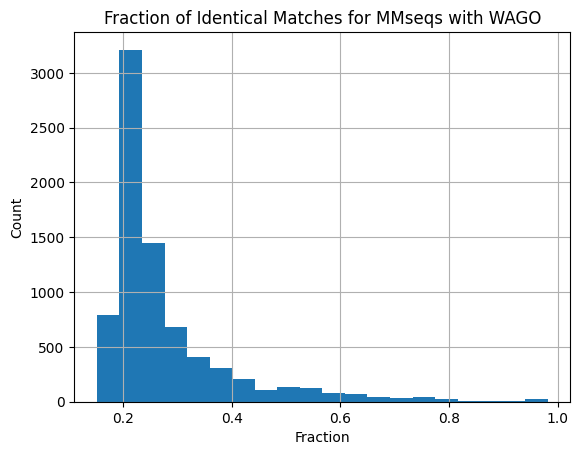

224

In [4]:
### Plot histogram

clade = 'WAGO'
df_tmp = mmseqs_df_dict[clade]
df_tmp['fident'].hist(bins=20)
plt.title(f'Fraction of Identical Matches for MMseqs with {clade}')
plt.xlabel('Fraction')
plt.ylabel('Count')
plt.show()
len(df_tmp[df_tmp['fident'] > 0.5]['target'].unique())

In [14]:
### Check whether true Argonaute from other clades are identified as similar sequences

clade1 = 'WAGO'
clade_set = {'AGO', 'WAGO', 'PIWI'}
clade2, clade3 = clade_set - {clade1}
true_ids = true_id_dict[clade2] + true_id_dict[clade3]
df_tmp = mmseqs_df_dict[clade1]
df_tmp[df_tmp['target'].isin(true_ids)]

,query,target,fident,alnlen,mismatch,gapopen,qstart,qend,qlen,tstart,tend,tlen,evalue,bits,taxid,taxname,Clade
2971,Q86NJ8,P34681,0.192,543,423,0,323,846,887,418,960,1040,7.477000e-19,106,6239,Caenorhabditis elegans,WAGO_like
2973,Q86NJ8,G5EC94,0.192,543,423,0,323,846,887,410,952,1032,9.861000e-19,105,6239,Caenorhabditis elegans,WAGO_like
4510,A0A0U1RML5,P34681,0.193,543,422,0,323,846,887,418,960,1040,1.873000e-19,108,6239,Caenorhabditis elegans,WAGO_like
4513,A0A0U1RML5,G5EC94,0.193,543,422,0,323,846,887,410,952,1032,2.471000e-19,107,6239,Caenorhabditis elegans,WAGO_like


In [17]:
len(df_tmp[df_tmp['fident'] > 0.193]['target'].unique())

2401

## Sequence length distribution

In [ ]:
ago_seqs = [len(v['seq']) for v in ago_fasta_dict.values()]
wago_seqs = [len(v['seq']) for v in wago_fasta_dict.values()]
piwi_seqs = [len(v['seq']) for v in piwi_fasta_dict.values()]

plt.hist([ago_seqs, wago_seqs, piwi_seqs], label=['ago', 'wago', 'piwi'], bins=10)
plt.legend()
plt.show()

In [ ]:
ago_mmseqs_df['tlen'].hist(bins=20)
wago_mmseqs_df['tlen'].hist(bins=20)
piwi_mmseqs_df['tlen'].hist(bins=20)

## Sampling sequences

In [ ]:
### Sample Sequences

num_seqs = 2000

ago_seq_ids = [i for i in true_ago_ids]
piwi_seq_ids = [i for i in true_piwi_ids]
wago_seq_ids = [i for i in true_wago_ids]

low = 750
high = 1200

ago_mmseqs_df_filtered = ago_mmseqs_df[(low<ago_mmseqs_df['tlen']) & (ago_mmseqs_df['tlen']<high)]
wago_mmseqs_df_filtered = wago_mmseqs_df[(low<wago_mmseqs_df['tlen']) & (wago_mmseqs_df['tlen']<high)]
piwi_mmseqs_df_filtered = piwi_mmseqs_df[(low<piwi_mmseqs_df['tlen']) & (piwi_mmseqs_df['tlen']<high)]

ago_seq_ids += ago_mmseqs_df_filtered['target'].drop_duplicates().sample(n=num_seqs - len(ago_seq_ids), replace=False).tolist()
wago_seq_ids += wago_mmseqs_df_filtered['target'].drop_duplicates().sample(n=num_seqs - len(wago_seq_ids), replace=False).tolist()
piwi_seq_ids += piwi_mmseqs_df_filtered['target'].drop_duplicates().sample(n=num_seqs - len(piwi_seq_ids), replace=False).tolist()

target_ids = set(ago_seq_ids + wago_seq_ids + piwi_seq_ids)  # the order will change here
print(f'Unique target ids: {len(target_ids)}')

In [ ]:
### Output (1) sampled target_ids and (2) target_id - clade 

sampled_id_path = '/home/moon/projects/AgoAnalysis/mmseqs/sampled_target_ids_0307.txt'
with open(sampled_id_path, 'w') as f:
    f.write('\n'.join(target_ids))

id2clade_path = '/home/moon/projects/AgoAnalysis/mmseqs/id2clade.tsv'
concat_df[['target', 'Clade']].to_csv(id2clade_path, sep='\t', index=False, header=False)

In [ ]:
def read_id2clade(path):
    id2clade = {}
    true_ids = ['AGO', 'PIWI', 'WAGO']
    with open(path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            target, clade = line.rstrip().split('\t')
            if target not in id2clade.keys():
                id2clade[target] = clade if clade in true_ids else 'Other'
            else:
                if id2clade[target] in true_ids:
                    continue
                elif clade in true_ids:
                    id2clade[target] = clade
                else:
                    id2clade[target] = 'Other'
    return id2clade    

In [ ]:
### Check count per target_id

# from collections import Counter

# id2clade = read_id2clade(id2clade_path)
# freq = Counter(id2clade.values())

In [ ]:
# concat_df_merged = concat_df.groupby('target')['Clade'].apply(lambda x: '-'.join(sorted(x.unique()))).reset_index()
# id2clade = concat_df_merged.set_index('target')['Clade'].to_dict()

In [ ]:
### Run MSA via clustalo for the sampled fasta

# sampled_fasta = '/home/moon/projects/AgoAnalysis/fasta/Argonaute_mmseqs_sampled.fasta'
# db_fasta = '/home/moon/src/mmseqs/databases/UniProtKB.fasta'
# sampled_msa = '/home/moon/projects/AgoAnalysis/msa/Argnoaute_mmseqs_sampled.msa.fasta '

# !seqkit grep -f  {sampled_id_path} {db_fasta} --id-regexp "\|([^\|]+)\|" -o {sampled_fasta}
# !clustalo -i {sampled_fasta} -o {sampled_msa} --outfmt=fasta -v 

# HMMER

In [6]:
import re

def read_hmmout(hmmout_path):
    data = []
    with open(hmmout_path, 'r') as file:
        capture_data = False
        for line in file:
            if 'Description' in line:
                capture_data = True
                continue
            if 'Domain' in line:
                break
    
            if capture_data:
                if re.match(r'^\s+\d', line):
                    columns = line.strip().split()
                    if len(columns) >= 9:
                        data.append({
                            'E-value_full': columns[0],
                            'score_full': columns[1],
                            'bias_full': columns[2],
                            'E-value_domain': columns[3],
                            'score_domain': columns[4],
                            'bias_domain': columns[5],
                            'exp': columns[6],
                            'N': columns[7],
                            'Sequence': columns[8],
                            'Description': ' '.join(columns[9:])
                        })
    hmm_df = pd.DataFrame(data)
    hmm_df = hmm_df.astype({'E-value_full': 'float64', 'score_full': 'float64', 'bias_full': 'float64', 
                    'E-value_domain': 'float64', 'score_domain': 'float64', 'bias_domain': 'float64',
                    'exp': 'float64', 'N': 'int32', 'Sequence': 'str', 'Description': 'str'})
    hmm_df['target'] = hmm_df['Sequence'].map(lambda x: x.split('|')[1])
    new_order = ['target'] + list(hmm_df.columns[:-1])
    hmm_df = hmm_df[new_order]
    return hmm_df

In [7]:
### Load HMMER outputs

ago_hmmout = f'/home/moon/projects/AgoAnalysis/hmmer/AGO.msa.hmm.out'
piwi_hmmout = f'/home/moon/projects/AgoAnalysis/hmmer/PIWI.msa.hmm.out'
wago_hmmout = f'/home/moon/projects/AgoAnalysis/hmmer/WAGO.msa.hmm.out'

ago_hmm_df = read_hmmout(ago_hmmout)
piwi_hmm_df = read_hmmout(piwi_hmmout)
wago_hmm_df = read_hmmout(wago_hmmout)

hmmer_df_dict = {'AGO': ago_hmm_df, 'PIWI': piwi_hmm_df, 'WAGO': wago_hmm_df}

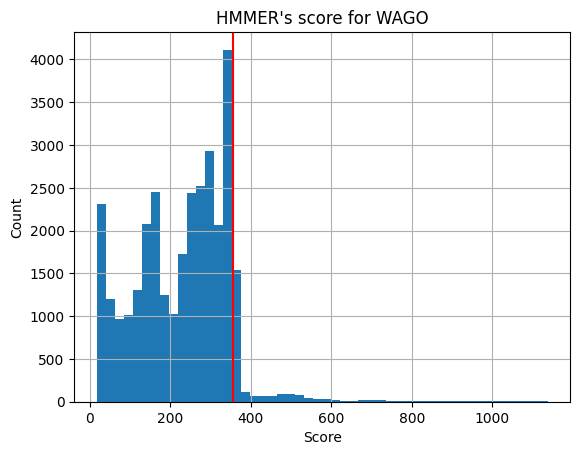

In [12]:
### Plot histogram

clade = 'WAGO'
clade2, clade3 = {'AGO', 'PIWI', 'WAGO'} - {clade}

df1 = hmmer_df_dict[clade]
df1['score_full'].hist(bins=50)

true_ids = true_id_dict[clade2] + true_id_dict[clade3]
threshold = df1[df1['target'].isin(true_ids)]['score_full'].max()
plt.axvline(x=threshold, color='r', )

plt.title(f"HMMER's score for {clade}")
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

In [ ]:
hmmer_df_dict['WAGO']

In [ ]:
### Check if true Argonaute sequences from the other clades are identified as homologs

clade1 = 'WAGO'
clade2 = 'AGO'
clade3 = 'PIWI'
df1 = hmmer_df_dict[clade1]
true_ids = true_id_dict[clade2] + true_id_dict[clade3]

df1[df1['target'].isin(true_ids)]

In [ ]:
threshold = df1[df1['target'].isin(true_ids)]['score_full'].max()
len(df1[df1['score_full'] > threshold])

# Phylogeny

In [ ]:
# def create_id2name(directory):
#     id2name = {}
#     for filename in os.listdir(directory):
#         if filename.endswith(".txt"):
#             file_path = os.path.join(directory, filename)
#             with open(file_path, 'r') as file:
#                 first_line = file.readline().strip()
#                 # Check if the line starts with ">"
#                 if first_line.startswith(">"):
#                     # Extract the header (excluding the description)
#                     header = first_line.split()[0][1:]  # Remove ">" and take the first word
#                     id2name[header] = filename.replace('.txt', '')
#     return id2name
    
# dirpath = '/Users/nagai/CSHL/Projects/AgoAnalysis/data/Sequences/AGO-clade'
# id2name = create_id2name(dirpath)
# ago_id2name = create_id2name(ago_dir)
# wago_id2name = create_id2name(wago_dir)
# piwi_id2name = create_id2name(piwi_dir)

# Hard-coding the dictionaries
ago_id2name = {'sp|O61931|ERGO1_CAEEL': 'CeERGO-1', 'sp|Q8CJG0|AGO2_MOUSE': 'MmAgo2', 'sp|Q9QZ81|AGO2_RAT': 'RnAgo2', 'tr|G5EEH0|G5EEH0_CAEEL': 'CeRDE-1', 'tr|A0A8V0Y222|A0A8V0Y222_CHICK': 'GgAgo2', 'tr|G5EES3|G5EES3_CAEEL': 'CeALG-1', 'sp|Q9H9G7|AGO3_HUMAN': 'HsAgo3', 'sp|Q9UKV8|AGO2_HUMAN': 'HsAgo2', 'tr|O16720|O16720_CAEEL': 'CeALG-2', 'sp|Q9UL18|AGO1_HUMAN': 'HsAgo1', 'tr|Q32KD4|Q32KD4_DROME': 'DmAgo1', 'tr|G5EC94|G5EC94_CAEEL': 'CeALG-3', 'sp|Q9HCK5|AGO4_HUMAN': 'HsAgo4', 'sp|P34681|TAG76_CAEEL': 'CeALG-4', 'tr|Q9XVI3|Q9XVI3_CAEEL': 'CeALG-5', 'sp|Q746M7|AGO_THET2': 'TtAgo', 'sp|Q9SHF3|AGO2_ARATH': 'AtAgo', 'tr|A0A8U0S055|A0A8U0S055_MUSPF': 'MputfAgo2'}
wago_id2name = {'tr|A0A0U1RML5|A0A0U1RML5_CAEEL': 'CeSAGO-2', 'tr|A0A0T7CIX3|A0A0T7CIX3_CAEEL': 'CeSAGO-1', 'tr|A8XRG0|A8XRG0_CAEBR': 'CbrCSR', 'sp|Q09249|YQ53_CAEEL': 'CeHRDE-1', 'tr|Q9XVF1|Q9XVF1_CAEEL': 'CeVSRA-1', 'tr|Q9TXN7|Q9TXN7_CAEEL': 'CeWAGO-10', 'tr|E3M6J3|E3M6J3_CAERE': 'CreCSR', 'tr|H2KZD5|H2KZD5_CAEEL': 'CeCSR-1a', 'sp|Q21691|NRDE3_CAEEL': 'CeNRDE-3', 'tr|A0A2G5U890|A0A2G5U890_9PELO': 'CniCSR', 'tr|A8WQA0|A8WQA0_CAEBR': 'CbrHRDE-1', 'tr|Q86NJ8|Q86NJ8_CAEEL': 'CePPW-1', 'tr|Q9N585|Q9N585_CAEEL': 'CePPW-2', 'sp|Q21770|WAGO1_CAEEL': 'CeWAGO-1', 'sp|O62275|WAGO4_CAEEL': 'CeWAGO-4'}
piwi_id2name = {'sp|Q7Z3Z4|PIWL4_HUMAN': 'HsPIWIL4', 'tr|P90786|P90786_CAEEL': 'CePRG-1', 'sp|Q96J94|PIWL1_HUMAN': 'HsPIWIL1', 'sp|Q8TC59|PIWL2_HUMAN': 'HsPIWIL2', 'sp|Q7Z3Z3|PIWL3_HUMAN': 'HsPIWIL3', 'sp|Q9VKM1|PIWI_DROME': 'DmPIWI', 'sp|A8D8P8|SIWI_BOMMO': 'BmSIWI'}
all_id2name = {'AGO': ago_id2name, 'PIWI': piwi_id2name, 'WAGO': wago_id2name}

In [ ]:
tree_path = '/home/moon/projects/AgoAnalysis/raxml/RAxML_bestTree.argonaute'
with open(tree_path, 'r') as f:
    newick_str = f.read().strip()

for clade, id2name in all_taxa_dict.items():
    for k, v in id2name.items():
        newick_str = newick_str.replace(k, f'{v} "{clade}"')

newick_str